<a href="https://colab.research.google.com/github/ayushsubramanian/LoRAXL-Trainer-and-Image-Generator/blob/main/LoRAXL_trainer_imageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭐️ Google Colab LoRA XL Model Trainer

❗**Colab Premium is recommended.**
However you can still train for free if you load a diffusers model, it will just take much longer.  


The setup, captioning, and training sections are based on the work of [Hollowstrawberry](https://github.com/hollowstrawberry/kohya-colab). Thank you!

In [ ]:
import os
import re
import toml
from time import time
from huggingface_hub import HfFileSystem
from IPython.display import Markdown, display
global dependencies_installed

# These carry information from past executions
if "model_url" in globals():
  old_model_url = model_url
else:
  old_model_url = None
if "dependencies_installed" not in globals():
  dependencies_installed = False
if "model_file" not in globals():
  model_file = None

# These may be set by other cells, some are legacy
if "custom_dataset" not in globals():
  custom_dataset = None
if "override_dataset_config_file" not in globals():
  override_dataset_config_file = None
if "override_config_file" not in globals():
  override_config_file = None

COLAB = True
SOURCE = "https://github.com/qaneel/kohya-trainer"
COMMIT = None
BETTER_EPOCH_NAMES = True
LOAD_TRUNCATED_IMAGES = True
try:
  LOWRAM = int(next(line.split()[1] for line in open('/proc/meminfo') if "MemTotal" in line)) / (1024**2) < 15
except:
  LOWRAM = False

#@title ## 1️⃣ Setup
#@markdown Your project name will be the same as the folder containing your images. Spaces aren't allowed.
project_name = "anime_lora" #@param {type:"string"}
#@markdown The folder structure doesn't matter and is up to preference. Make sure to always pick the same one.
folder_structure = "Organize by project (MyDrive/Loras/project_name/dataset)" #@param ["Organize by category (MyDrive/lora_training/datasets/project_name)", "Organize by project (MyDrive/Loras/project_name/dataset)"]
#@markdown Decide the model that will be downloaded and used for training. You can also choose your own by pasting its download link.
training_model = "Stable Diffusion XL 1.0 base" #@param ["Pony Diffusion V6 XL", "Animagine XL V3", "Stable Diffusion XL 1.0 base"]
optional_custom_training_model_url = "" #@param {type:"string"}
#@markdown Using a diffusers model utilizes less resources and is recommended if you are using Colab's free plan. The 3 options above will work with or without diffusers.
load_diffusers = True #@param {type:"boolean"}

if optional_custom_training_model_url:
  model_url = optional_custom_training_model_url
else:
  if load_diffusers:
    model_url = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/"
  else:
    model_url = "https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/sd_xl_base_1.0.safetensors"

if load_diffusers:
  vae_file= "stabilityai/sdxl-vae"
else:
  vae_url = "https://huggingface.co/stabilityai/sdxl-vae/resolve/main/sdxl_vae.safetensors"
  vae_file = "/content/sdxl_vae.safetensors"

root_dir = "/content" if COLAB else "~/Loras"
deps_dir = os.path.join(root_dir, "deps")
repo_dir = os.path.join(root_dir, "kohya-trainer")

if "/Loras" in folder_structure:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/Loras") if COLAB else root_dir
  log_folder    = os.path.join(main_dir, "_logs")
  config_folder = os.path.join(main_dir, project_name)
  images_folder = os.path.join(main_dir, project_name, "dataset")
  output_folder = os.path.join(main_dir, project_name, "output")
else:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/lora_training") if COLAB else root_dir
  images_folder = os.path.join(main_dir, "datasets", project_name)
  output_folder = os.path.join(main_dir, "output", project_name)
  config_folder = os.path.join(main_dir, "config", project_name)
  log_folder    = os.path.join(main_dir, "log")

config_file = os.path.join(config_folder, "training_config.toml")
dataset_config_file = os.path.join(config_folder, "dataset_config.toml")
accelerate_config_file = os.path.join(repo_dir, "accelerate_config/config.yaml")

for dir in (main_dir, deps_dir, repo_dir, log_folder, images_folder, output_folder, config_folder):
  os.makedirs(dir, exist_ok=True)

def install_dependencies():
  os.chdir(root_dir)
  !git clone {SOURCE} {repo_dir}
  os.chdir(repo_dir)
  if COMMIT:
    !git reset --hard {COMMIT}
  !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/train_network_xl_wrapper.py -q -O train_network_xl_wrapper.py
  !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/dracula.py -q -O dracula.py

  !apt -y update -qq
  !apt -y install aria2 -qq
  !pip install torch==2.2.1+cu121 accelerate==0.19.0 transformers==4.30.2 diffusers==0.18.2 bitsandbytes==0.40.0.post4 opencv-python==4.7.0.68 jax==0.4.23 jaxlib==0.4.23
  !pip install pytorch-lightning==1.9.0 voluptuous==0.13.1 toml==0.10.2 ftfy==6.1.1 einops==0.6.0 safetensors pygments
  !pip install invisible-watermark==0.2.0 open-clip-torch==2.20.0 dadaptation==3.1 prodigyopt==1.0 lion-pytorch==0.1.2
  !pip install -e .
  !pip install -U accelerate
  !pip install -U huggingface-hub
  !pip install diffusers
  !pip install -U fairscale

  # if cross_attention == "xformers":
  #   !pip install -q xformers==0.0.26.dev778

  # patch kohya for minor stuff
  if LOWRAM:
    !sed -i "s@cpu@cuda@" library/model_util.py
  if LOAD_TRUNCATED_IMAGES:
    !sed -i 's/from PIL import Image/from PIL import Image, ImageFile\nImageFile.LOAD_TRUNCATED_IMAGES=True/g' library/train_util.py # fix truncated jpegs error
  if BETTER_EPOCH_NAMES:
    !sed -i 's/{:06d}/{:02d}/g' library/train_util.py # make epoch names shorter
    !sed -i 's/"." + args.save_model_as)/"-{:02d}.".format(num_train_epochs) + args.save_model_as)/g' train_network.py # name of the last epoch will match the rest

  from accelerate.utils import write_basic_config
  if not os.path.exists(accelerate_config_file):
    write_basic_config(save_location=accelerate_config_file)

  os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
  os.environ["BITSANDBYTES_NOWELCOME"] = "1"
  os.environ["SAFETENSORS_FAST_GPU"] = "1"

def download_model():
  global old_model_url, model_url, model_file, vae_url, vae_file
  real_model_url = model_url.strip()

  if load_diffusers:
    if 'huggingface.co' in real_model_url:
        match = re.search(r'huggingface\.co/([^/]+)/([^/]+)', real_model_url)
        if match:
            username = match.group(1)
            model_name = match.group(2)
            model_file = f"{username}/{model_name}"
            fs = HfFileSystem()
            existing_folders = set(fs.ls(model_file, detail=False))
            necessary_folders = [ "scheduler", "text_encoder", "text_encoder_2", "tokenizer", "tokenizer_2", "unet", "vae" ]
            if all(f"{model_file}/{folder}" in existing_folders for folder in necessary_folders):
              print("🔘 Diffusers model identified.")
              return True
    print("💥 Failed to load Diffusers model.")

  if not model_file:
    if real_model_url.lower().endswith((".ckpt", ".safetensors")):
      model_file = f"/content{real_model_url[real_model_url.rfind('/'):]}"
    else:
      model_file = "/content/downloaded_model.safetensors"
      if os.path.exists(model_file):
        !rm "{model_file}"

  if m := re.search(r"(?:https?://)?(?:www\.)?huggingface\.co/[^/]+/[^/]+/blob", model_url):
    real_model_url = real_model_url.replace("blob", "resolve")
  elif m := re.search(r"(?:https?://)?(?:www\\.)?civitai\.com/models/([0-9]+)(/[A-Za-z0-9-_]+)?", model_url):
    if m.group(2):
      model_file = f"/content{m.group(2)}.safetensors"
    if m := re.search(r"modelVersionId=([0-9]+)", model_url):
      real_model_url = f"https://civitai.com/api/download/models/{m.group(1)}"
    else:
      raise ValueError("optional_custom_training_model_url contains a civitai link, but the link doesn't include a modelVersionId. You can also right click the download button to copy the direct download link.")

  !aria2c "{real_model_url}" --console-log-level=warn -c -s 16 -x 16 -k 10M -d / -o "{model_file}"

  if not os.path.exists(vae_file):
    !aria2c "{vae_url}" --console-log-level=warn -c -s 16 -x 16 -k 10M -d / -o "{vae_file}"

  if model_file.lower().endswith(".safetensors"):
    from safetensors.torch import load_file as load_safetensors
    try:
      test = load_safetensors(model_file)
      del test
    except:
      #if "HeaderTooLarge" in str(e):
      new_model_file = os.path.splitext(model_file)[0]+".ckpt"
      !mv "{model_file}" "{new_model_file}"
      model_file = new_model_file
      print(f"Renamed model to {os.path.splitext(model_file)[0]}.ckpt")

  if model_file.lower().endswith(".ckpt"):
    from torch import load as load_ckpt
    try:
      test = load_ckpt(model_file)
      del test
    except:
      return False

  return True


print("\n📄 Installing dependencies...\n")
t0 = time()
install_dependencies()
t1 = time()
dependencies_installed = True
print(f"\n✅ Installation finished in {int(t1-t0)} seconds.")


if old_model_url != model_url or not model_file or not os.path.exists(model_file):
  print("\n🔄 Downloading model...")
  if not download_model():
    print("\n💥 Error: The model you selected is invalid or corrupted, or couldn't be downloaded. You can use a civitai or huggingface link, or any direct download link.")
  print()
else:
  print("\n🔄 Model already downloaded.\n")



📄 Installing dependencies...

fatal: destination path '/content/kohya-trainer' already exists and is not an empty directory.
62 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
ERROR: Could not find a version that satisfies the requirement torch==2.2.1+cu121 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0)
ERROR: No matching distribution found for torch==2.2.1+cu121
Obtaining file:///content/kohya-trainer
  Preparing metadata (setup.py) ... done
  Attempting uninstall: library
    Found existing installation: library 0.0.0
    Uninstalling library-0.0.0:
      Successfully uninstalled libr

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


🔘 Diffusers model identified.



In [ ]:
#@title #2️⃣ Upload Images
#@markdown Upload your dataset of images into the dataset folder of your project which was created by the previous cell.

from google.colab import files
import shutil

# Function to upload files and move them to a destination folder
def upload_and_move(destination_folder):
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Move each uploaded file to the destination folder
        shutil.move(filename, destination_folder)
        print(f'{filename} moved to {destination_folder}')

        if os.path.exists(filename):
            os.remove(filename)

destination_folder = f'/content/drive/MyDrive/Loras/{project_name}/dataset/'
upload_and_move(destination_folder)

Saving anime_style_21.jpeg to anime_style_21.jpeg
Saving anime_style_01.jpeg to anime_style_01.jpeg
Saving anime_style_02.jpeg to anime_style_02.jpeg
Saving anime_style_03.jpeg to anime_style_03.jpeg
Saving anime_style_04.jpeg to anime_style_04.jpeg
Saving anime_style_05.jpeg to anime_style_05.jpeg
Saving anime_style_06.jpeg to anime_style_06.jpeg
Saving anime_style_07.jpeg to anime_style_07.jpeg
Saving anime_style_08.jpeg to anime_style_08.jpeg
Saving anime_style_09.jpeg to anime_style_09.jpeg
Saving anime_style_10.jpeg to anime_style_10.jpeg
Saving anime_style_11.jpeg to anime_style_11.jpeg
Saving anime_style_12.jpeg to anime_style_12.jpeg
Saving anime_style_13.jpeg to anime_style_13.jpeg
Saving anime_style_14.jpeg to anime_style_14.jpeg
Saving anime_style_15.jpeg to anime_style_15.jpeg
Saving anime_style_16.jpeg to anime_style_16.jpeg
Saving anime_style_17.jpeg to anime_style_17.jpeg
Saving anime_style_18.jpeg to anime_style_18.jpeg
Saving anime_style_19.jpeg to anime_style_19.jpeg


In [ ]:
#@title #3️⃣ BLIP Captioning
#@markdown BLIP is a pre-training framework for unified vision-language understanding and generation, which achieves state-of-the-art results on a wide range of vision-language tasks. It can be used as a tool for image captioning which will later help train your model.
import os

os.chdir("/content/kohya-trainer/finetune")

min_length = 5 #@param {type:"slider", min:0, max:100, step:5.0}
max_length = 75 #@param {type:"slider", min:0, max:100, step:5.0}

config = {
    "_train_data_dir"   : images_folder,
    "batch_size"        : 8,
    "beam_search"       : True,
    "min_length"        : min_length,
    "max_length"        : max_length,
    "debug"             : True,
    "caption_extension" : ".txt",
    "max_data_loader_n_workers" : 2,
    "recursive"         : True
}

args = ""
for k, v in config.items():
    if k.startswith("_"):
        args += f'"{v}" '
    elif isinstance(v, str):
        args += f'--{k}="{v}" '
    elif isinstance(v, bool) and v:
        args += f"--{k} "
    elif isinstance(v, float) and not isinstance(v, bool):
        args += f"--{k}={v} "
    elif isinstance(v, int) and not isinstance(v, bool):
        args += f"--{k}={v} "

final_args = f"python make_captions.py {args}"

os.chdir("/content/kohya-trainer/finetune")
!{final_args}

load images from /content/drive/MyDrive/Loras/anime_lora/dataset
found 30 images.
loading BLIP caption: https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
tokenizer_config.json: 100% 48.0/48.0 [00:00<00:00, 332kB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 4.19MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 20.8MB/s]
config.json: 100% 570/570 [00:00<00:00, 4.55MB/s]
100% 1.66G/1.66G [00:12<00:00, 148MB/s]
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
BLIP loaded
  0% 0/4 [00:00<?, ?it/s]/content/drive/MyDrive/Loras/anime_lora/dataset/anime_style_01.jpeg two people in school uniforms sitting on a bus
/content/drive/MyDrive/Loras/anime_lora/dataset/anime_style_02.jpeg two anime characters are sitting together in a room
/content/drive/MyDrive/Loras/anime_lora/dataset/anime_style_03.jpeg a girl in a library with a book
/content/drive/MyDrive/Loras/anime_lora/dataset/anime_s

In [ ]:
#@title #4️⃣ Training
#@markdown ### ▶️ Prep
#@markdown Re-type project name to train model without having to run previous cells again in case of refresh errors.
project_name = "anime_lora" #@param {type:"string"}
#@markdown ### ▶️ Processing
resolution = 1024 #param {type:"slider", min:768, max:1536, step:128}
caption_extension = ".txt" #param {type:"string"}
#@markdown Shuffling tags in place improves learning and prompting. An activation tag goes at the start of every text file and will not be shuffled.<p>
shuffle_tags = True #@param {type:"boolean"}
shuffle_caption = shuffle_tags
activation_tags = "2" #@param [0,1,2,3]
keep_tokens = int(activation_tags)

#@markdown ### ▶️ Steps <p>
#@markdown Your images will repeat this number of times during training. Recommended that your images multiplied by their repeats is between 200 and 400.
num_repeats = 10 #@param {type:"number"}
#@markdown Choose how long you want to train for. A good starting point is around 10 epochs or around 2000 steps.<p>
#@markdown One epoch is a number of steps equal to: your number of images multiplied by their repeats, divided by batch size. <p>
preferred_unit = "Epochs" #@param ["Epochs", "Steps"]
how_many = 10 #@param {type:"number"}
max_train_epochs = how_many if preferred_unit == "Epochs" else None
max_train_steps = how_many if preferred_unit == "Steps" else None
#@markdown Saving more epochs will let you compare your Lora's progress better.
save_every_n_epochs = 10 #@param {type:"number"}
keep_only_last_n_epochs = 10 #@param {type:"number"}
if not save_every_n_epochs:
  save_every_n_epochs = max_train_epochs
if not keep_only_last_n_epochs:
  keep_only_last_n_epochs = max_train_epochs

#@markdown ### ▶️ Learning
#@markdown The learning rate is the most important for your results. If you want to train slower with lots of images, or if your dim and alpha are high, move the unet to 2e-4 or lower. <p>
#@markdown The text encoder helps your Lora learn concepts slightly better. It is recommended to make it half or a fifth of the unet. If you're training a style you can even set it to 0.
unet_lr = 3e-4 #@param {type:"number"}
text_encoder_lr = 6e-5 #@param {type:"number"}
#@markdown The scheduler is the algorithm that guides the learning rate. If you're not sure, pick `constant` and ignore the number. However it is recommended to use `cosine_with_restarts` with 3 restarts.
lr_scheduler = "cosine_with_restarts" #@param ["constant", "cosine", "cosine_with_restarts", "constant_with_warmup", "linear", "polynomial"]
lr_scheduler_number = 3 #@param {type:"number"}
lr_scheduler_num_cycles = lr_scheduler_number if lr_scheduler == "cosine_with_restarts" else 0
lr_scheduler_power = lr_scheduler_number if lr_scheduler == "polynomial" else 0
#@markdown Steps spent "warming up" the learning rate during training for efficiency. Recommended to leave it at 5%.
lr_warmup_ratio = 0.05 #@param {type:"slider", min:0.0, max:0.2, step:0.01}
lr_warmup_steps = 0
#@markdown Adjusts loss over time, makes learning much more efficient. Recommended to set to 5.0 for general purposes and 8.0 for anime. Higher value makes it less strict. Set to 0 to disable.
min_snr_gamma = 5 #@param {type:"slider", min:4.0, max:16.0, step:0.5}

#@markdown ### ▶️ Structure
#@markdown LoRA is the classic type and good for a variety of purposes. LoCon is good with artstyles as it has more layers to learn more aspects of the dataset.
lora_type = "LoRA" #@param ["LoRA", "LoCon"]

#@markdown Below are some recommended XL values for the following settings:

#@markdown | type | network_dim | network_alpha | conv_dim | conv_alpha |
#@markdown | :---: | :---: | :---: | :---: | :---: |
#@markdown | Regular LoRA | 8 | 4 |  -- |  -- |
#@markdown | Style LoCon | 16 | 8 | 16 | 8 |

#@markdown More dim means larger Lora and can hold more information, but more isn't always necessarily better.
network_dim = 8 #@param {type:"slider", min:1, max:32, step:1}
network_alpha = 4 #@param {type:"slider", min:1, max:32, step:1}
#@markdown The following two values only apply to the additional layers of LoCon.
conv_dim = 16 #@param {type:"slider", min:1, max:32, step:1}
conv_alpha = 1 #@param {type:"slider", min:1, max:32, step:1}

network_module = "networks.lora"
network_args = None
if lora_type.lower() == "locon":
  network_args = [f"conv_dim={conv_dim}", f"conv_alpha={conv_alpha}"]

#@markdown ### ▶️ Training
#@markdown Adjust these parameters depending on your colab configuration.
#@markdown If you're using the free tier you should select a diffusers model at the top of this cell.
#@markdown
#@markdown Higher batch size is often faster but uses more memory.
train_batch_size = 4 #@param {type:"slider", min:1, max:16, step:1}
#@markdown There is no substantial difference between sdpa and xformers.
cross_attention = "sdpa" #@param ["sdpa", "xformers"]
#@markdown If you're on an A100 you should enable bf16.
mixed_precision = "fp16" #@param ["bf16", "fp16"]
#@markdown Caching latents to drive will add a 250KB file next to each image but will use considerably less memory.
cache_latents = True #@param {type:"boolean"}
cache_latents_to_drive = True #@param {type:"boolean"}
#@markdown The following option will turn off shuffle_tags and disable text encoder training.
cache_text_encoder_outputs  = False  # @param {type:"boolean"}

#@markdown ### ▶️ Advanced
#@markdown The optimizer is the algorithm used for training. AdanW8Bit is the default and works great, while Prodigy manages learning rate automatically and may have several advantages such as training faster due to needing less steps as well as working better for small datasets.
optimizer = "Prodigy" #@param ["AdamW8bit", "Prodigy", "DAdaptation", "DadaptAdam", "DadaptLion", "AdamW", "Lion", "SGDNesterov", "SGDNesterov8bit", "AdaFactor"]
#@markdown Recommended args for AdamW8bit: `weight_decay=0.1 betas=[0.9,0.99]`<p>
#@markdown Recommended args for Prodigy: `decouple=True weight_decay=0.01 betas=[0.9,0.999] d_coef=2 use_bias_correction=True safeguard_warmup=True`
optimizer_args = "decouple=True weight_decay=0.01 betas=[0.9,0.999] d_coef=2 use_bias_correction=True safeguard_warmup=True" #@param {type:"string"}
optimizer_args = [a.strip() for a in optimizer_args.split(' ') if a]
#@markdown If Dadapt or Prodigy are selected and this box is checked, the following recommended values will override any previous settings:<p>
#@markdown `unet_lr=0.75`, `text_encoder_lr=0.75`, `network_alpha=network_dim`
recommended_values_for_prodigy = True #@param {type:"boolean"}

if any(opt in optimizer.lower() for opt in ["dadapt", "prodigy"]):
  if recommended_values_for_prodigy:
    unet_lr = 0.75
    text_encoder_lr = 0.75
    network_alpha = network_dim

#@markdown ### ▶️ Ready
#@markdown You can now run this cell to train your Lora! <p>


# The cool code is down here...

def validate_dataset():
  global lr_warmup_steps, lr_warmup_ratio, caption_extension, keep_tokens
  supported_types = (".png", ".jpg", ".jpeg", ".webp", ".bmp")

  print("\n💿 Checking dataset...")
  if not project_name.strip() or any(c in project_name for c in " .()\"'\\/"):
    print("💥 Error: Please choose a valid project name.")
    return

  if custom_dataset:
    try:
      datconf = toml.loads(custom_dataset)
      datasets = [d for d in datconf["datasets"][0]["subsets"]]
    except:
      print(f"💥 Error: Your custom dataset is invalid or contains an error! Please check the original template.")
      return
    reg = [d.get("image_dir") for d in datasets if d.get("is_reg", False)]
    datasets_dict = {d["image_dir"]: d["num_repeats"] for d in datasets}
    folders = datasets_dict.keys()
    files = [f for folder in folders for f in os.listdir(folder)]
    images_repeats = {folder: (len([f for f in os.listdir(folder) if f.lower().endswith(supported_types)]), datasets_dict[folder]) for folder in folders}
  else:
    reg = []
    folders = [images_folder]
    files = os.listdir(images_folder)
    images_repeats = {images_folder: (len([f for f in files if f.lower().endswith(supported_types)]), num_repeats)}

  for folder in folders:
    if not os.path.exists(folder):
      print(f"💥 Error: The folder {folder.replace('/content/drive/', '')} doesn't exist.")
      return
  for folder, (img, rep) in images_repeats.items():
    if not img:
      print(f"💥 Error: Your {folder.replace('/content/drive/', '')} folder is empty.")
      return
  for f in files:
    if not f.lower().endswith((".txt", ".npz")) and not f.lower().endswith(supported_types):
      print(f"💥 Error: Invalid file in dataset: \"{f}\". Aborting.")
      return

  if not [txt for txt in files if txt.lower().endswith(".txt")]:
    caption_extension = ""

  pre_steps_per_epoch = sum(img*rep for (img, rep) in images_repeats.values())
  steps_per_epoch = pre_steps_per_epoch/train_batch_size
  total_steps = max_train_steps or int(max_train_epochs*steps_per_epoch)
  estimated_epochs = int(total_steps/steps_per_epoch)
  lr_warmup_steps = int(total_steps*lr_warmup_ratio)

  for folder, (img, rep) in images_repeats.items():
    print("📁 "+folder.replace("/content/drive/", "") + (" (Regularization)" if folder in reg else ""))
    print(f"📈 Found {img} images with {rep} repeats, equaling {img*rep} steps.")
  print(f"📉 Divide {pre_steps_per_epoch} steps by {train_batch_size} batch size to get {steps_per_epoch} steps per epoch.")
  if max_train_epochs:
    print(f"🔮 There will be {max_train_epochs} epochs, for around {total_steps} total training steps.")
  else:
    print(f"🔮 There will be {total_steps} steps, divided into {estimated_epochs} epochs and then some.")

  if total_steps > 10000:
    print("💥 Error: Your total steps are too high. You probably made a mistake. Aborting...")
    return

  return True

def create_config():
  global dataset_config_file, config_file, model_file

  if override_config_file:
    config_file = override_config_file
    print(f"\n⭕ Using custom config file {config_file}")
  else:
    config_dict = {
      "network_arguments": {
        "unet_lr": unet_lr,
        "text_encoder_lr": text_encoder_lr if not cache_text_encoder_outputs else 0,
        "network_dim": network_dim,
        "network_alpha": network_alpha,
        "network_module": network_module,
        "network_args": network_args,
        "network_train_unet_only": text_encoder_lr == 0 or cache_text_encoder_outputs,
      },
      "optimizer_arguments": {
        "learning_rate": unet_lr,
        "lr_scheduler": lr_scheduler,
        "lr_scheduler_num_cycles": lr_scheduler_num_cycles if lr_scheduler == "cosine_with_restarts" else None,
        "lr_scheduler_power": lr_scheduler_power if lr_scheduler == "polynomial" else None,
        "lr_warmup_steps": lr_warmup_steps if lr_scheduler != "constant" else None,
        "optimizer_type": optimizer,
        "optimizer_args": optimizer_args if optimizer_args else None,
      },
      "training_arguments": {
        "pretrained_model_name_or_path": model_file,
        "vae": vae_file,
        "max_train_steps": max_train_steps,
        "max_train_epochs": max_train_epochs,
        "train_batch_size": train_batch_size,
        "seed": 42,
        "max_token_length": 225,
        "xformers": cross_attention == "xformers",
        "sdpa": cross_attention == "sdpa",
        "min_snr_gamma": min_snr_gamma if min_snr_gamma > 0 else None,
        "lowram": LOWRAM,
        "no_half_vae": True,
        "gradient_checkpointing": True,
        "gradient_accumulation_steps": 1,
        "max_data_loader_n_workers": 8,
        "persistent_data_loader_workers": True,
        "mixed_precision": mixed_precision,
        "full_bf16": mixed_precision == "bf16",
        "cache_latents": cache_latents,
        "cache_latents_to_disk": cache_latents_to_drive,
        "cache_text_encoder_outputs": cache_text_encoder_outputs,
        "min_timestep": 0,
        "max_timestep": 1000,
        "prior_loss_weight": 1.0,
      },
      "saving_arguments": {
        "save_precision": "fp16",
        "save_model_as": "safetensors",
        "save_every_n_epochs": save_every_n_epochs,
        "save_last_n_epochs": keep_only_last_n_epochs,
        "output_name": project_name,
        "output_dir": output_folder,
        "log_prefix": project_name,
        "logging_dir": log_folder,
      }
    }

    for key in config_dict:
      if isinstance(config_dict[key], dict):
        config_dict[key] = {k: v for k, v in config_dict[key].items() if v is not None}

    with open(config_file, "w") as f:
      f.write(toml.dumps(config_dict))
    print(f"\n📄 Config saved to {config_file}")

  if override_dataset_config_file:
    dataset_config_file = override_dataset_config_file
    print(f"⭕ Using custom dataset config file {dataset_config_file}")
  else:
    dataset_config_dict = {
      "general": {
        "resolution": resolution,
        "shuffle_caption": shuffle_caption and not cache_text_encoder_outputs,
        "keep_tokens": keep_tokens,
        "flip_aug": False,
        "caption_extension": caption_extension,
        "enable_bucket": True,
        "bucket_no_upscale": False,
        "bucket_reso_steps": 64,
        "min_bucket_reso": 256,
        "max_bucket_reso": 4096,
      },
      "datasets": toml.loads(custom_dataset)["datasets"] if custom_dataset else [
        {
          "subsets": [
            {
              "num_repeats": num_repeats,
              "image_dir": images_folder,
              "class_tokens": None if caption_extension else project_name
            }
          ]
        }
      ]
    }

    for key in dataset_config_dict:
      if isinstance(dataset_config_dict[key], dict):
        dataset_config_dict[key] = {k: v for k, v in dataset_config_dict[key].items() if v is not None}

    with open(dataset_config_file, "w") as f:
      f.write(toml.dumps(dataset_config_dict))
    print(f"📄 Dataset config saved to {dataset_config_file}")


def main():

  if not validate_dataset():
    return

  create_config()

  print("\n⭐ Starting trainer...\n")
  os.chdir(repo_dir)

  !accelerate launch --quiet --config_file={accelerate_config_file} --num_cpu_threads_per_process=1 train_network_xl_wrapper.py --dataset_config={dataset_config_file} --config_file={config_file}

  if not get_ipython().__dict__['user_ns']['_exit_code']:
    display(Markdown("### ✅ Done! Your downloadable Lora will be available in the output folder of the project."))

main()



💿 Checking dataset...
📁 MyDrive/Loras/anime_lora/dataset
📈 Found 30 images with 10 repeats, equaling 300 steps.
📉 Divide 300 steps by 4 batch size to get 75.0 steps per epoch.
🔮 There will be 10 epochs, for around 750 total training steps.

📄 Config saved to /content/drive/MyDrive/Loras/anime_lora/training_config.toml
📄 Dataset config saved to /content/drive/MyDrive/Loras/anime_lora/dataset_config.toml

⭐ Starting trainer...

Loading settings from /content/drive/MyDrive/Loras/anime_lora/training_config.toml...
/content/drive/MyDrive/Loras/anime_lora/training_config
prepare tokenizers
tokenizer_config.json: 100% 905/905 [00:00<00:00, 6.53MB/s]
vocab.json: 100% 961k/961k [00:00<00:00, 11.8MB/s]
merges.txt: 100% 525k/525k [00:00<00:00, 60.9MB/s]
special_tokens_map.json: 100% 389/389 [00:00<00:00, 2.71MB/s]
tokenizer.json: 100% 2.22M/2.22M [00:00<00:00, 57.8MB/s]
tokenizer_config.json: 100% 904/904 [00:00<00:00, 7.28MB/s]
vocab.json: 100% 862k/862k [00:00<00:00, 98.4MB/s]
merges.txt: 100%

### ✅ Done! Your downloadable Lora will be available in the output folder of the project.

# ⭐️ Image Generation using Text-to-Image pipeline
This txt2img pipeline generates images based on text prompts using the Stable Diffusion XL model and incorporates the Lora model fine-tuned in the previous section for customized results and image generation.

In [ ]:
#@title ## 1️⃣ Prep
#@markdown Run this cell to install necessary packages and files.

# Install necessary packages
!pip install --upgrade pip
!pip install --upgrade diffusers transformers accelerate peft
!pip install torch-model-archiver
!pip install google-cloud-aiplatform

# Change directory to /content/
%cd /content/

# Download the file from Hugging Face
!wget https://huggingface.co/SG161222/RealVisXL_V4.0/resolve/main/RealVisXL_V4.0.safetensors?download=true --content-disposition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 41.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
/content
--2024-07-25 16:13:20--  https://huggingface.co/SG161222/RealVisXL_V4.0/resolve/main/RealVisXL_V4.0.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 99.84.108.129, 99.84.108.87, 99.84.108.55, ...
Connecting to huggingface.co (huggingface.co)|99.84.108.129|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locati

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

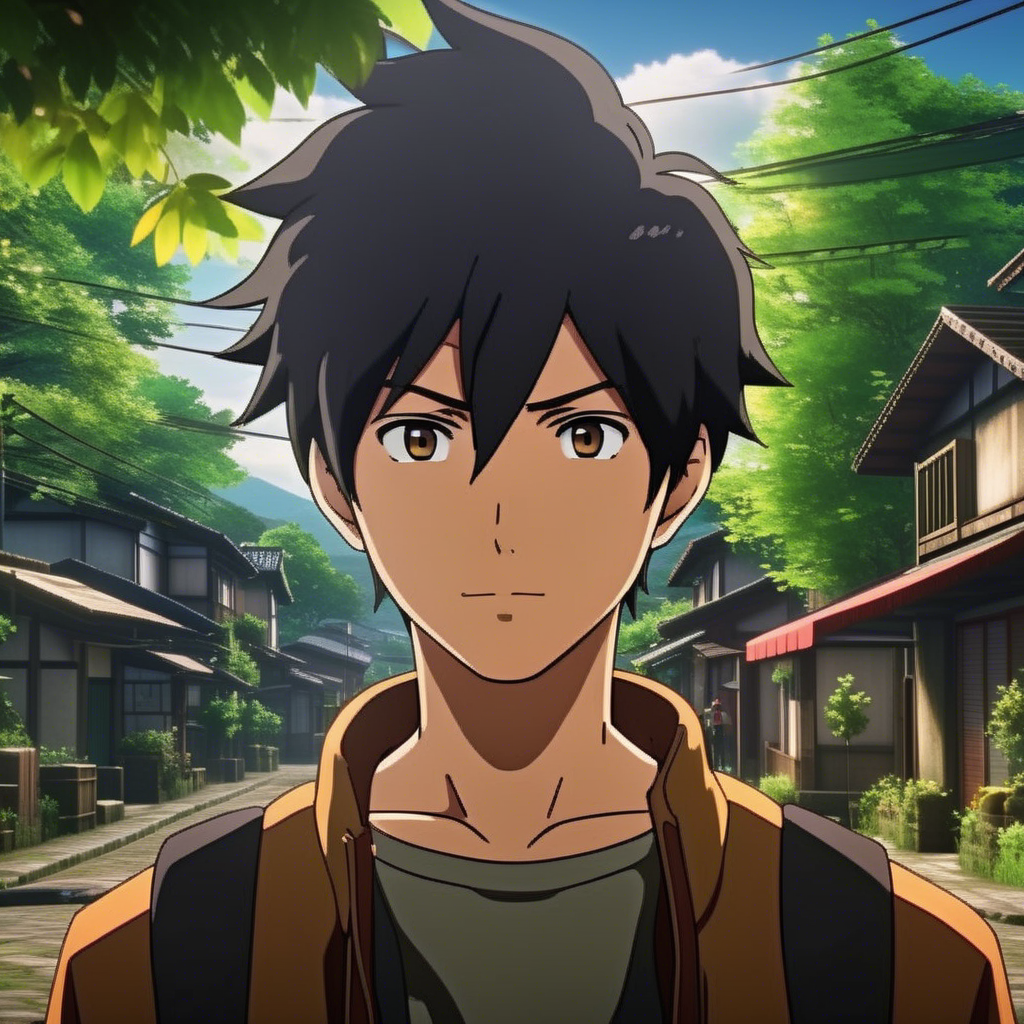

In [ ]:
#@title ## 2️⃣ Text-to-Image Generation
import diffusers
from huggingface_hub import hf_hub_download
from diffusers import DPMSolverMultistepScheduler

# Load the Stable Diffusion XL model
# pipe = diffusers.StableDiffusionXLPipeline.from_single_file("/content/RealVisXL_V4.0.safetensors")
pipe = diffusers.StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0")

# Load LoRA weights
pipe.load_lora_weights(f"/content/drive/MyDrive/Loras/{project_name}/output/{project_name}-10.safetensors", adapter_name="feng")

# Set and fuse LoRA adapters
pipe.set_adapters(["feng"], adapter_weights=[0.85])
pipe.fuse_lora()

# Set the scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Move the pipeline to CUDA
pipe.to("cuda")

# Define interactive inputs using @param
prompt = "centre screen photo of a man as an anime character, looking at the camera, dark and gritty, highly detailed face, full face, trees in the background, small town in the background, 8 k resolution, ultra-realistic, octane render, unreal engine." #@param {type:"string"}
#@markdown You can provide an optional negative prompt to specify undesired attributes or aspects to avoid.
negative_prompt = "render, drawing, bad photo, bad photography, closed eyes, worst quality, low quality, blurry, bad teeth, deformed teeth, deformed lips, bad anatomy, bad proportions, deformed face, ugly face, bad face, morbid, mutilated, mutation, disfigured" #@param {type:"string"}
#@markdown A higher strength value increases the prompt's impact, leading to results more closely aligned with the specified prompt, while a lower value reduces its influence.
strength = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}

# Generate an image using the pipeline with the given parameters
image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps = 50, strength=strength, guidance_scale = 15).images[0]
image


# ⭐️ Image Generation using Image-to-Image pipeline
This img2img pipeline generates images based on input images using the Stable Diffusion XL model and incorporates the LoRA model fine-tuned in the previous section for customized results and enhanced image generation.

In [ ]:
#@title ## 1️⃣ Prep
#@markdown Run this cell to install necessary packages and files.

# Install necessary packages
!pip install --upgrade pip
!pip install --upgrade diffusers transformers accelerate peft
!pip install torch-model-archiver
!pip install google-cloud-aiplatform

# Change directory to /content/
%cd /content/

# Download the file from Hugging Face
!wget https://huggingface.co/SG161222/RealVisXL_V4.0/resolve/main/RealVisXL_V4.0.safetensors?download=true --content-disposition

/content
--2024-07-25 16:19:25--  https://huggingface.co/SG161222/RealVisXL_V4.0/resolve/main/RealVisXL_V4.0.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 99.84.108.55, 99.84.108.70, 99.84.108.87, ...
Connecting to huggingface.co (huggingface.co)|99.84.108.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/55/f2/55f2bd474e0e90c2f35cf2532c075330af997c184ac041f98c884dc3db8bdffc/912c9dc74f5855175c31a7993f863a043ac8dcc31732b324cd05d75cd7e16844?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27RealVisXL_V4.0.safetensors%3B+filename%3D%22RealVisXL_V4.0.safetensors%22%3B&Expires=1722183566&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMjE4MzU2Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzU1L2YyLzU1ZjJiZDQ3NGUwZTkwYzJmMzVjZjI1MzJjMDc1MzMwYWY5OTdjMTg0YWMwNDFmOThjODg0ZGMzZGI4YmRmZmMvOTEyYzlkYzc0ZjU4NTUxNzVjM

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Image loaded successfully.


  0%|          | 0/50 [00:00<?, ?it/s]

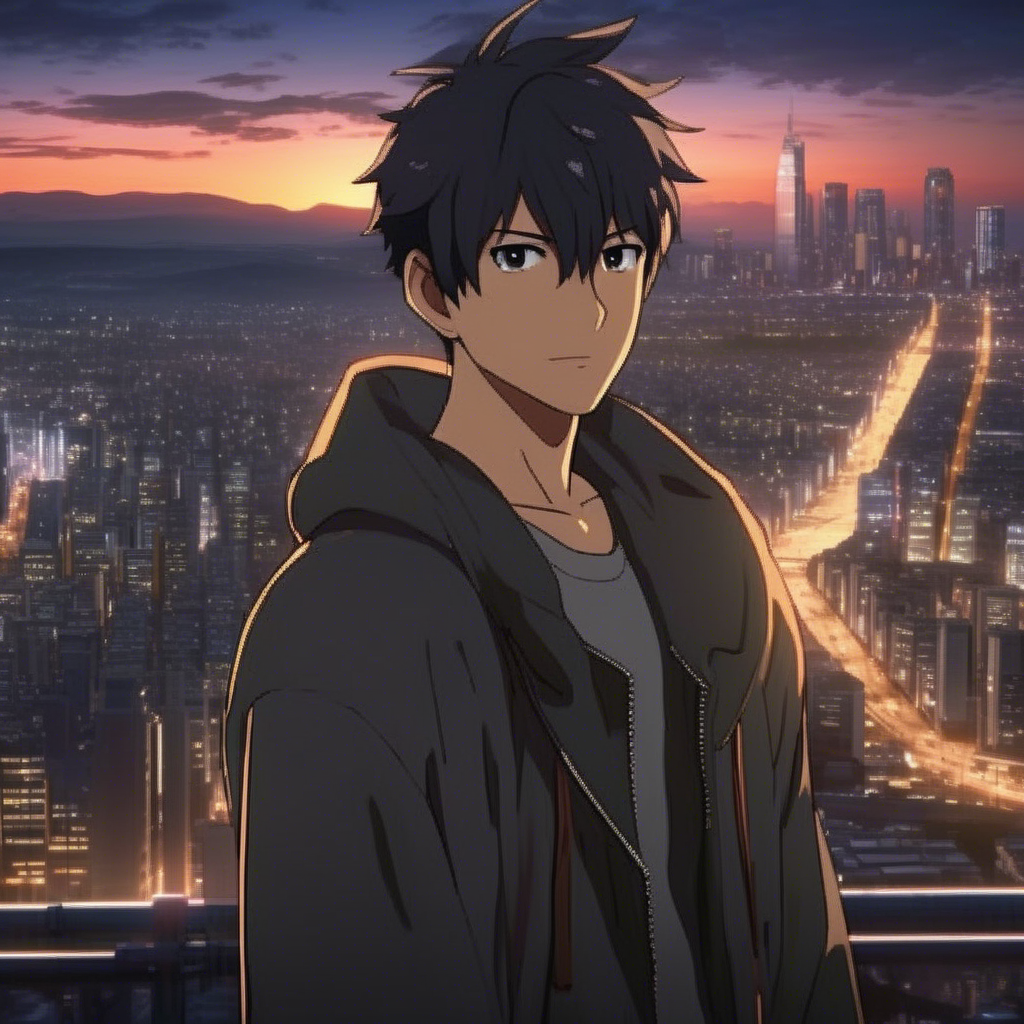

In [ ]:
#@title ## 2️⃣ Image-to-Image Generation
import diffusers
from huggingface_hub import hf_hub_download
from diffusers import DPMSolverMultistepScheduler
from PIL import Image
import torch

# Load the Stable Diffusion XL model
# pipe = diffusers.StableDiffusionXLPipeline.from_single_file("/content/RealVisXL_V4.0.safetensors")
pipe = diffusers.StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16)

# Load LoRA weights
pipe.load_lora_weights(f"/content/drive/MyDrive/Loras/{project_name}/output/{project_name}-10.safetensors", adapter_name="feng")

# Set and fuse LoRA adapters
pipe.set_adapters(["feng"], adapter_weights=[0.85])
pipe.fuse_lora()

# Set the scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Move the pipeline to CUDA
pipe.to("cuda")

# Define interactive inputs using @param
#@markdown Upload your image into Colab and specify its file path.
file_path = "/content/my_face.png" #@param {type:"string"}
prompt = "centre screen photo of a man as an anime character, looking at the camera, dark and gritty, highly detailed face, full face, city landscape in background, night time, bright lights, 8 k resolution, ultra-realistic, octane render, unreal engine." #@param {type:"string"}
#@markdown You can provide an optional negative prompt to specify undesired attributes or aspects to avoid.
negative_prompt = "render, drawing, bad photo, bad photography, closed eyes, worst quality, low quality, blurry, bad teeth, deformed teeth, deformed lips, bad anatomy, bad proportions, deformed face, ugly face, bad face, morbid, mutilated, mutation, disfigured" #@param {type:"string"}
#@markdown A higher strength value increases the influence of the input image and prompt, making the output more closely resemble the desired result. A lower strength value reduces this influence, leading to results that stay closer to the original image while incorporating the prompt’s details.
strength = 0.25 #@param {type:"slider", min:0, max:1, step:0.05}

# Open the input image from the specified file path
image = Image.open(file_path)

# Verify if the image is read correctly
if image is None:
    print("Error: Image not loaded correctly.")
else:
    print("Image loaded successfully.")

# Generate an image using the pipeline with the given parameters
image = pipe(prompt=prompt, image=image, negative_prompt=negative_prompt, num_inference_steps=50, strength=strength).images[0]
image
